In [1]:
from myPackage.my_module import *
from scipy import optimize

In [2]:
#Random state is
rand_PSDM(4)

array([[ 0.47561-0.j     ,  0.1193 -0.02544j, -0.02501-0.04974j,
         0.10425+0.13424j],
       [ 0.1193 +0.02544j,  0.06763+0.j     , -0.05311+0.02187j,
         0.00974+0.02336j],
       [-0.02501+0.04974j, -0.05311-0.02187j,  0.19734+0.j     ,
        -0.02122+0.13891j],
       [ 0.10425-0.13424j,  0.00974-0.02336j, -0.02122-0.13891j,
         0.25943-0.j     ]])

In [3]:
#Random separable state is
tens_prod2d(rand_PSDM(2), rand_PSDM(2))

array([[ 0.5912 -0.j     , -0.09038+0.05511j, -0.06941+0.19111j,
        -0.0072 -0.03568j],
       [-0.09038-0.05511j,  0.11548+0.j     ,  0.02842-0.02274j,
        -0.01356+0.03733j],
       [-0.06941-0.19111j,  0.02842+0.02274j,  0.24539+0.j     ,
        -0.03751+0.02287j],
       [-0.0072 +0.03568j, -0.01356-0.03733j, -0.03751-0.02287j,
         0.04793+0.j     ]])

In [3]:
def wer(th, v=1, base='psim'):
    '''
    Creates Werner state based on parameters of angle, visibility and Bell state
    Args:
        th: angle
        v: visibility (default=1)
        base: which Bell state to choose. Accepts one of the strings: "psip", "psim", "phip", "phim"
        which means phi/psi with plus (p) or minus (m) sign (default="psim")
    Returns:
        4x4 np.ndarray
    
    '''
    match base:
        case 'psim':
            vec = np.sin(th)*OneZero - np.cos(th)*ZeroOne
        case 'psip':
            vec = np.sin(th)*OneZero + np.cos(th)*ZeroOne
        case 'phip':
            vec = np.sin(th)*OneOne + np.cos(th)*ZeroZero
        case 'phim':
            vec =np.sin(th)*OneOne - np.cos(th)*ZeroZero
        case _:
            raise ValueError("You must choose one of the following: psip, psim, phip, phim")
    return v * np.outer(vec,vec) + (1-v)/4 * np.identity(4)

In [24]:
def phi_proj(matrixA, target='fidelity'):
    '''
    Performs a unitary rotation and projects onto phi+ state (optimizes for fidelity, distance or concurrence)
    Args:
        matrixA: matrix to be projected
        target: function to be optimizes for. One of the following: 'fidelity', 'distance' or 'concurrence'
    Returns:
        A dict object:
            fidelity/distance/concurrence: optimal value of the target function
            parameters: 2x3 angles of unitary rotation
            angle: angle of resulting phi+ state
            visiblity: visibility of resulting phi+ state
            projected: np.matrix result of projection
            original: np.matrix original matrix
    '''
    def get_params_phi(matrix):
        v = 1 - 4*matrix[1,1]
        if v==0:
            return 0, 0    
        alph = np.arcsin(matrix[0,3]/v*2)/2
        return alph, v
    
    
    from scipy.optimize import differential_evolution
    def projection(matrix):
        return np.real(np.matrix([[matrix[0,0],0,0,matrix[0,3]/2+matrix[3,0]/2],\
                                  [0,matrix[2,2]/2+matrix[1,1]/2,0,0],\
                                  [0,0,matrix[2,2]/2+matrix[1,1]/2,0],\
                                  [matrix[0,3]/2+matrix[3,0]/2,0,0,matrix[3,3]]]))
    
    def f(params, matrixA):
        matrixA = matrixA.matrix if type(matrixA) == density_matrix else matrixA
        paramsA = params[:3]
        paramsB = params[3:]
        rotated = rotate_matrix(matrixA, paramsA, paramsB)
        projected = projection(rotated)
        if target=='fidelity':
            return -1*matrix_fidelity(density_matrix(projected), matrixA)
        if target=='concurrence':
            return -1*concurrence(projected)
        if target=='distance':
            return Frobenius_dist(matrixA, projected)
    bounds = [(0,2*pi), (0,2*pi), (0,2*pi), (0,2*pi), (0,2*pi), (0,2*pi)]
    res = differential_evolution(f, args=(matrixA,), bounds=bounds)
    
    if target=='distance':
        res['fun'] = -res['fun']
        
    paramsA = res['x'][:3]
    paramsB = res['x'][3:]
    matrix_proj = projection(rotate_matrix(matrixA, paramsA, paramsB))
    angle, vis = get_params_phi(matrix_proj)
    dist = Frobenius_dist(matrix_proj, matrixA)
    conc = concurrence(density_matrix(matrix_proj))
    fid = matrix_fidelity(matrixA, matrix_proj)   
    return {'distance': dist, 'concurrence' : conc, 'fidelity': fid,\
            'parameters': [paramsA, paramsB], 'angle': angle,\
            'visibility': vis, 'projected': matrix_proj, 'original': matrixA}

In [25]:
state = rand_PSDM(4)
res = phi_proj(state, target='distance')
res

c:\Users\Jan\Desktop\Uni_Wrrr\Kwantowa_informacja\Magisterka\WernerTomography2\myPackage\my_module.py:53: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if(params!='rand'):


{'distance': 0.4550169813489622,
 'concurrence': 0,
 'fidelity': 0.7214370988949913,
 'parameters': [array([3.12114, 3.31351, 1.48845]),
  array([3.04409, 6.09443, 3.10822])],
 'angle': 0.5397364138538197,
 'visibility': 0.28970220353285525,
 'projected': matrix([[0.38853, 0.     , 0.     , 0.12772],
         [0.     , 0.17757, 0.     , 0.     ],
         [0.     , 0.     , 0.17757, 0.     ],
         [0.12772, 0.     , 0.     , 0.25632]]),
 'original': array([[ 0.38854+0.j     , -0.05781+0.01329j, -0.06737+0.18135j,
          0.12771-0.1818j ],
        [-0.05781-0.01329j,  0.04557+0.j     , -0.04232-0.01115j,
         -0.00633+0.03398j],
        [-0.06737-0.18135j, -0.04232+0.01115j,  0.30958-0.j     ,
         -0.02706-0.09087j],
        [ 0.12771+0.1818j , -0.00633-0.03398j, -0.02706+0.09087j,
          0.25631-0.j     ]])}

In [26]:
res2 = phi_proj(state, target='fidelity')
res2

{'distance': 0.47603573831490165,
 'concurrence': 0.1315340448822303,
 'fidelity': 0.732500810372438,
 'parameters': [array([6.04704, 2.43293, 0.08002]),
  array([0.2348 , 0.32141, 4.8057 ])],
 'angle': 0.4971660650122747,
 'visibility': 0.4718591950172253,
 'projected': matrix([[0.461  , 0.     , 0.     , 0.1978 ],
         [0.     , 0.13204, 0.     , 0.     ],
         [0.     , 0.     , 0.13204, 0.     ],
         [0.1978 , 0.     , 0.     , 0.27493]]),
 'original': array([[ 0.38854+0.j     , -0.05781+0.01329j, -0.06737+0.18135j,
          0.12771-0.1818j ],
        [-0.05781-0.01329j,  0.04557+0.j     , -0.04232-0.01115j,
         -0.00633+0.03398j],
        [-0.06737-0.18135j, -0.04232+0.01115j,  0.30958-0.j     ,
         -0.02706-0.09087j],
        [ 0.12771+0.1818j , -0.00633-0.03398j, -0.02706+0.09087j,
          0.25631-0.j     ]])}

In [27]:
res2 = phi_proj(state, target='concurrence')
res2

C:\Users\Jan\AppData\Local\Temp\ipykernel_14568\504766868.py:20: RuntimeWarning: invalid value encountered in arcsin
  alph = np.arcsin(matrix[0,3]/v*2)/2


{'distance': 0.6956300979155818,
 'concurrence': 0.13153662510310005,
 'fidelity': 0.5443253669370616,
 'parameters': [array([3.20039, 1.72666, 6.17326]),
  array([2.86124, 2.54846, 4.56023])],
 'angle': nan,
 'visibility': 0.30415589522519837,
 'projected': matrix([[ 0.33393,  0.     ,  0.     , -0.23973],
         [ 0.     ,  0.17396,  0.     ,  0.     ],
         [ 0.     ,  0.     ,  0.17396,  0.     ],
         [-0.23973,  0.     ,  0.     ,  0.31814]]),
 'original': array([[ 0.38854+0.j     , -0.05781+0.01329j, -0.06737+0.18135j,
          0.12771-0.1818j ],
        [-0.05781-0.01329j,  0.04557+0.j     , -0.04232-0.01115j,
         -0.00633+0.03398j],
        [-0.06737-0.18135j, -0.04232+0.01115j,  0.30958-0.j     ,
         -0.02706-0.09087j],
        [ 0.12771+0.1818j , -0.00633-0.03398j, -0.02706+0.09087j,
          0.25631-0.j     ]])}

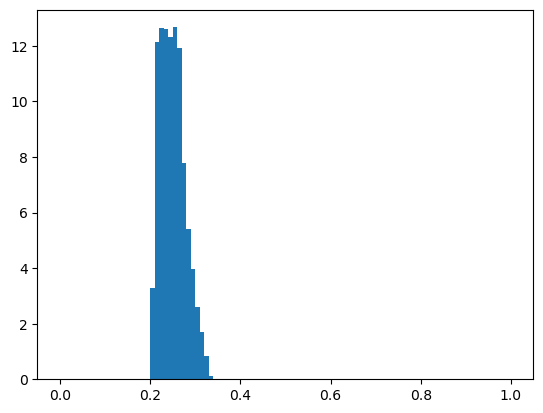

In [20]:
density_matrix(res['projected']).histogram()

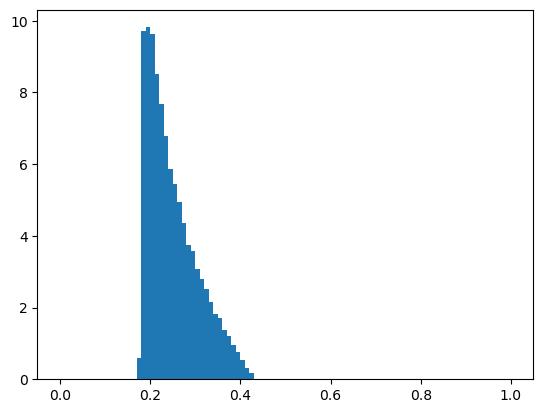

In [23]:
density_matrix(wer(res2['angle'], res2['visibility'], base='phip')).histogram()

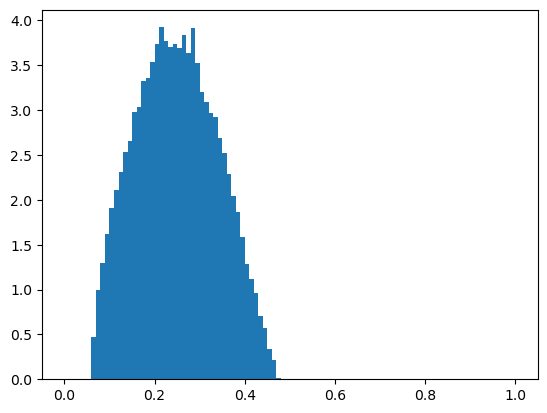

In [21]:
density_matrix(res['original']).histogram()

In [9]:
wer(pi/3, base ='phip')

array([[0.75   , 0.     , 0.     , 0.43301],
       [0.     , 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.     , 0.     ],
       [0.43301, 0.     , 0.     , 0.25   ]])

In [6]:
#tworzy instancje klasy z pięcioma pandas DataFrame
samps = load_samples('all_complex')

In [3]:
#DataFrame z kątem oraz widzialnością znalezionego optymalnego stanu
samps.OptimalState.head()

,Angle,Visibility
Index,,
0,0.285188,0.585148
1,0.460276,0.441305
2,0.437844,0.641831
3,0.107143,0.410110
4,0.217093,0.500638


In [5]:
#DataFrame z macierzą losowego stanu
samps.Matrix.head()

,"0,0","0,1","0,2","0,3","1,0","1,1","1,2","1,3","2,0","2,1","2,2","2,3","3,0","3,1","3,2","3,3"
Index,,,,,,,,,,,,,,,,
0,0.233679+0.000000j,-0.062283-0.043711j,0.138566-0.148810j,0.127721+0.031173j,-0.062283+0.043711j,0.150021+0.000000j,-0.013792+0.062795j,-0.000057-0.028551j,0.138566+0.148810j,-0.013792-0.062795j,0.425088+0.000000j,0.172618+0.125806j,0.127721-0.031173j,-0.000057+0.028551j,0.172618-0.125806j,0.191212+0.000000j
1,0.232214+0.000000j,0.063032-0.155730j,0.120695-0.050568j,0.113719+0.049571j,0.063032+0.155730j,0.366617+0.000000j,0.057062+0.076860j,-0.005565+0.036089j,0.120695+0.050568j,0.057062-0.076860j,0.111678+0.000000j,-0.005644+0.059368j,0.113719-0.049571j,-0.005565-0.036089j,-0.005644-0.059368j,0.289491+0.000000j
2,0.247616+0.000000j,-0.049387+0.040941j,0.073163-0.174477j,-0.050199-0.047633j,-0.049387-0.040941j,0.119367+0.000000j,-0.190204+0.045026j,-0.011427+0.089134j,0.073163+0.174477j,-0.190204-0.045026j,0.507887+0.000000j,0.080024-0.113257j,-0.050199+0.047633j,-0.011427-0.089134j,0.080024+0.113257j,0.125130+0.000000j
3,0.137583+0.000000j,0.039205+0.050675j,0.005024-0.075012j,0.044930-0.084346j,0.039205-0.050675j,0.303204+0.000000j,0.074109+0.061001j,0.038989-0.123985j,0.005024+0.075012j,0.074109-0.061001j,0.308768+0.000000j,0.202200-0.021050j,0.044930+0.084346j,0.038989+0.123985j,0.202200+0.021050j,0.250445+0.000000j
4,0.357644+0.000000j,-0.025868+0.091033j,0.164496+0.044290j,0.033732+0.078348j,-0.025868-0.091033j,0.240480+0.000000j,0.155648-0.121341j,0.048310+0.001038j,0.164496-0.044290j,0.155648+0.121341j,0.276546+0.000000j,0.073937+0.047693j,0.033732-0.078348j,0.048310-0.001038j,0.073937-0.047693j,0.125330+0.000000j


In [5]:
# DataFrame z parametrami obrotu, który maksymalizuje fidelity (3 parametry razy 2 kubity)
samps.Rotation.head()

,0,1,2,3,4,5
Index,,,,,,
0,4.301653,2.876516,2.138744,1.975735,0.452765,1.257931
1,5.969293,1.222776,5.349506,5.615224,1.263626,0.320845
2,1.956183,3.113735,5.142175,1.432167,4.922827,0.557264
3,4.248243,0.355534,5.855609,5.541380,3.069616,2.800975
4,5.599575,1.396426,4.851141,1.023605,4.511035,2.519872


In [8]:
#DataFrame z różnymi miarami
samps.Measures.head()

,Distance,MatrixFidelity,HistogramFidelity,Covering,ConcurrenceOriginal,ConcurrenceOpt,CHSHViolationMOriginal,CHSHViolationMOpt
Index,,,,,,,,
0,0.134917,0.948760,0.937120,0.90876,0.114023,0.067022,0.0,0.0
1,0.195771,0.911139,0.854492,0.79780,0.000000,0.000000,0.0,0.0
2,0.105442,0.957498,0.952583,0.93200,0.128604,0.086633,0.0,0.0
3,0.256375,0.872250,0.795017,0.76882,0.000000,0.000000,0.0,0.0
4,0.169950,0.933961,0.917178,0.88762,0.000000,0.000000,0.0,0.0


In [7]:
#DataFrame z kubełkami dla każdego badanego stanu
samps.Bins.head()

,"[0.0, 0.01]","[0.01, 0.02]","[0.02, 0.03]","[0.03, 0.04]","[0.04, 0.05]","[0.05, 0.06]","[0.06, 0.07]","[0.07, 0.08]","[0.08, 0.09]","[0.09, 0.1]",...,"[0.9, 0.91]","[0.91, 0.92]","[0.92, 0.93]","[0.93, 0.94]","[0.94, 0.95]","[0.95, 0.96]","[0.96, 0.97]","[0.97, 0.98]","[0.98, 0.99]","[0.99, 1.0]"
Index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.00000,0.00002,0.00118,0.00300,0.00608,0.01040,0.01472,0.01902,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.00062,0.00218,0.00356,0.00502,0.00734,0.00900,0.01196,0.01374,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.00000,0.00138,0.00368,0.00668,0.00990,0.01352,0.01664,0.02240,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.00112,0.00288,0.00502,0.00668,0.01002,0.01400,0.01512,0.01790,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.00000,0.00000,0.00000,0.00000,0.00024,0.00230,0.00618,0.01264,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


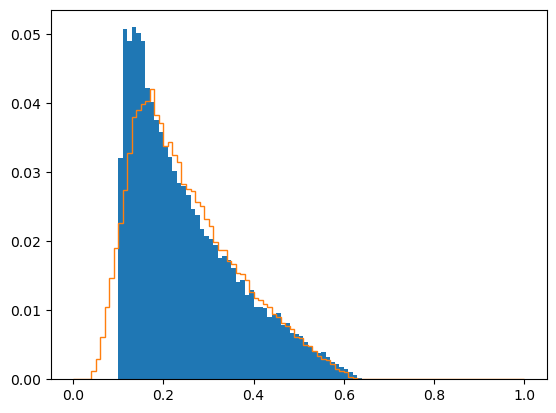

In [9]:
# Metoda do wywoływania histogramu - pomarańczowe schodki to stan losowy, a niebieskie to dopasowany.
# W argumencie jest index próbki
samps.double_plot(0)

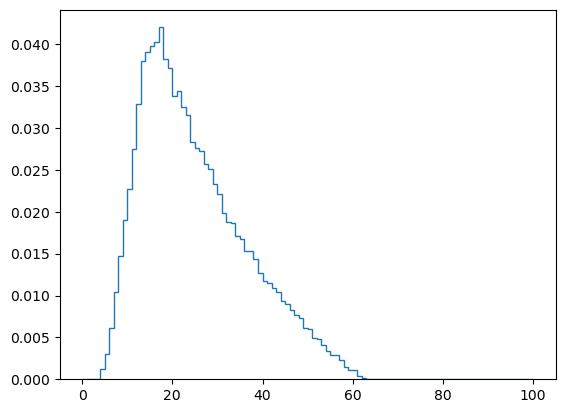

In [10]:
# Histogram tylko stanu losowego
samps.histogram(0)

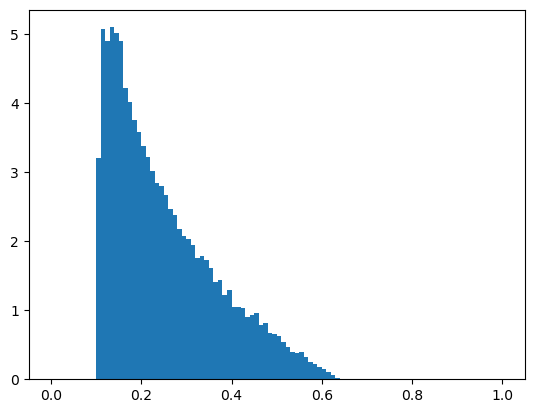

In [11]:
#Histogram tylko stanu dopasowanego
samps.opt_histogram(0)

In [13]:
# Tworzy instancję klasy density_matrix z macierzy stanu losowego

dm = samps.density_matrix(0)

In [15]:
# Tworzy instancję klasy density_matrix ze stanu Wernera o zadanym kącie th i widzialności vis
th=pi/2
vis = 1

wer = density_matrix(rho2(th,vis))

In [2]:
mean_over_unitars(rho2(pi/4,1))

array([[ 0.4336 +0.j     , -0.15985-0.0569j , -0.06363-0.15729j,
        -0.01839-0.43321j],
       [-0.15985+0.0569j ,  0.0664 +0.j     ,  0.0441 +0.04964j,
         0.06363+0.15729j],
       [-0.06363+0.15729j,  0.0441 -0.04964j,  0.0664 -0.j     ,
         0.15985+0.0569j ],
       [-0.01839+0.43321j,  0.06363-0.15729j,  0.15985-0.0569j ,
         0.4336 -0.j     ]])

(1.0000000000000004+1.6653345369377356e-16j)

In [18]:
#różne funkcje korzystające z density_matrix
print(matrix_fidelity(dm, wer))
print(Frobenius_dist(dm, wer))
print(concurrence(wer))
print(CHSHviolation_measure(wer))

0.4250876905292271
0.8210858019295816
1.2246467991473532e-16
0.0


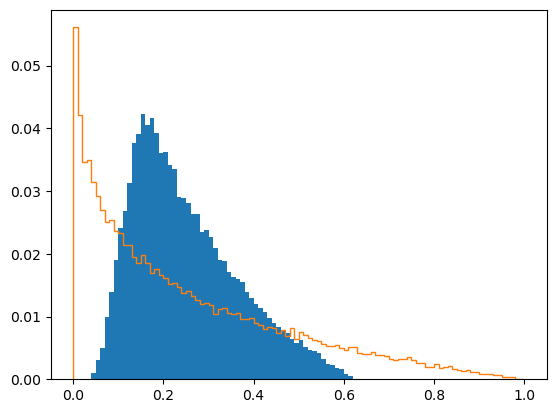

In [19]:
double_plot(dm, wer)

In [53]:
def optimal_trace(dmA):
    from scipy.optimize import differential_evolution, dual_annealing, brute, shgo
    def f(matrixA, params):
        matrixA = matrixA.matrix if type(matrixA) == density_matrix else matrixA
        matrixB = rho2(-pi/4,1)
        paramsA = params[:3]
        paramsB = params[3:]
        return -1*np.trace(np.matmul(matrixB, rotate_matrix(matrixA, paramsA, paramsB)))
    bounds = [(0,2*pi), (0,2*pi), (0,2*pi), (0,2*pi), (0,2*pi), (0,2*pi)]
    res = differential_evolution(f, args=(dmA,), bounds=bounds)
    return {'value': -np.real(res['fun']), 'parameters': [res['x'][:3], res['x'][3:]]}


In [55]:
def optimal_trace_shgo(dmA):
    from scipy.optimize import differential_evolution, dual_annealing, brute, shgo
    def f(params, matrixA):
        matrixA = matrixA.matrix if type(matrixA) == density_matrix else matrixA
        matrixB = rho2(-pi/4,1)
        paramsA = params[:3]
        paramsB = params[3:]
        return -1*np.trace(np.matmul(matrixB, rotate_matrix(matrixA, paramsA, paramsB)))
    bounds = [(0,2*pi), (0,2*pi), (0,2*pi), (0,2*pi), (0,2*pi), (0,2*pi)]
    res = shgo(f, args=(dmA,), bounds=bounds)
    return {'value': -np.real(res['fun']), 'parameters': [res['x'][:3], res['x'][3:]]}


In [56]:
ans = optimal_trace_shgo(rho2(pi,1))
ans

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [53]:
phip = np.matrix([[0.5,0,0,0.5],[0,0,0,0],[0,0,0,0],[0.5,0,0,0.5]])
phim = np.matrix([[0.5,0,0,-0.5],[0,0,0,0],[0,0,0,0],[-0.5,0,0,0.5]])

In [59]:
ans = optimal_trace(phim)
ans

{'value': 1.0000000000000002,
 'parameters': [array([2.12558, 3.12156, 1.59394]),
  array([2.58681, 6.26005, 1.59083])]}

In [64]:
state = rand_PSDM(4)
optimal_trace(state)

c:\Users\Jan\anaconda3\Lib\site-packages\scipy\optimize\_differentialevolution.py:1165: ComplexWarning: Casting complex values to real discards the imaginary part
  energies[0:S] = calc_energies
c:\Users\Jan\anaconda3\Lib\site-packages\scipy\optimize\_differentialevolution.py:1418: ComplexWarning: Casting complex values to real discards the imaginary part
  self.population_energies[candidate] = np.squeeze(energy)
c:\Users\Jan\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:598: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
c:\Users\Jan\anaconda3\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:356: ComplexWarning: Casting complex values to real discards the imaginary part
  _lbfgsb.setulb(m, x, low_bnd, upper_bnd, nbd, f, g, factr,
c:\Users\Jan\anaconda3\Lib\site-packages\scipy\optimize\_differentialevolution.py:1102: ComplexWarning: Casting complex values to real discards the imaginary part
  self.population_energies[0] = r

{'value': 0.5790848686035593,
 'parameters': [array([2.40665, 0.16564, 2.28091]),
  array([1.4232 , 5.2923 , 1.02036])]}

In [7]:
def wer_projection(state):
    import scipy.optimize
    
    def f(params):
        paramsA = params[:3]
        paramsB = params[3:]
        return -1*np.real(np.trace(np.dot(rotate_matrix(state, paramsA, paramsB), rho2(-pi/4,1))))
    res = scipy.optimize.differential_evolution(f, bounds=[(0,2*pi), (0,2*pi), (0,2*pi), (0,2*pi), (0,2*pi), (0,2*pi)])
    trace = -1*res['fun']
    
    nonlconstraint = optimize.NonlinearConstraint(lambda x:(x[1]*np.cos(x[0]-np.pi/4)*np.cos(x[0]-np.pi/4)-x[1]/4+1/4-trace),lb=0,ub=0)
    bounds = optimize.Bounds([-pi/4,0], [pi/4, 1])
    def concurrencerho(x):
        rho = rho2(x[0],x[1])  #making sure rho is of np.array type
        rhod = tens_prod2d(Pauli[2], Pauli[2])@np.transpose(np.conjugate(rho))@tens_prod2d(Pauli[2], Pauli[2])
        lambs = np.linalg.eigvals(rho@rhod)
        lambs = np.sqrt(lambs)
        l1 = max(lambs)
        C = 2*l1 - np.sum(lambs)
        return np.real(-C)
    
    return optimize.minimize(concurrencerho,x0=[-pi/4, 1], constraints=nonlconstraint, bounds=bounds, method='trust-constr')

In [8]:
state = rand_PSDM(4)
state

array([[ 0.15292+0.j     ,  0.02475-0.09847j, -0.013  +0.03944j,
         0.0354 +0.00799j],
       [ 0.02475+0.09847j,  0.25748-0.j     ,  0.10759-0.11799j,
         0.10544+0.17889j],
       [-0.013  -0.03944j,  0.10759+0.11799j,  0.22855+0.j     ,
         0.04599+0.18942j],
       [ 0.0354 -0.00799j,  0.10544-0.17889j,  0.04599-0.18942j,
         0.36105+0.j     ]])

In [10]:
concurrence(state)

0.00884212229911141

In [9]:
wer_projection(state)

           message: `gtol` termination condition is satisfied.
           success: True
            status: 1
               fun: -0.16751703929448514
                 x: [ 3.689e-01  5.692e-01]
               nit: 15
              nfev: 18
              njev: 6
              nhev: 0
          cg_niter: 5
      cg_stop_cond: 0
              grad: [-8.424e-01 -1.173e+00]
   lagrangian_grad: [ 4.322e-09 -3.105e-09]
            constr: [array([-2.044e-11]), array([ 3.689e-01,  5.692e-01])]
               jac: [array([[ 4.212e-01,  5.863e-01]]), array([[ 1.000e+00,  0.000e+00],
                           [ 0.000e+00,  1.000e+00]])]
       constr_nfev: [18, 0]
       constr_njev: [0, 0]
       constr_nhev: [0, 0]
                 v: [array([ 2.000e+00]), array([ 5.042e-08,  5.522e-08])]
            method: tr_interior_point
        optimality: 4.321874703599495e-09
  constr_violation: 2.043609725888018e-11
    execution_time: 0.05354666709899902
         tr_radius: 14553620.84073611
    con

In [16]:
wer_projection(rho2(pi/4, 1))

           message: `gtol` termination condition is satisfied.
           success: True
            status: 1
               fun: -0.999999991740099
                 x: [ 7.853e-01  1.000e+00]
               nit: 37
              nfev: 87
              njev: 29
              nhev: 0
          cg_niter: 28
      cg_stop_cond: 1
              grad: [-2.321e-04 -3.319e-01]
   lagrangian_grad: [-1.723e-12 -7.105e-15]
            constr: [array([-3.524e-09]), array([ 7.853e-01,  1.000e+00])]
               jac: [array([[ 1.160e-04,  7.500e-01]]), array([[ 1.000e+00,  0.000e+00],
                           [ 0.000e+00,  1.000e+00]])]
       constr_nfev: [87, 0]
       constr_njev: [0, 0]
       constr_nhev: [0, 0]
                 v: [array([-4.043e+01]), array([ 4.923e-03,  3.065e+01])]
            method: tr_interior_point
        optimality: 1.7234980803637612e-12
  constr_violation: 3.523628500090581e-09
    execution_time: 0.13340139389038086
         tr_radius: 474371.52471982635
    c

In [17]:
wer_projection(rho2(pi/4, 1))

           message: `gtol` termination condition is satisfied.
           success: True
            status: 1
               fun: -0.9999999847646485
                 x: [ 7.853e-01  1.000e+00]
               nit: 47
              nfev: 102
              njev: 34
              nhev: 0
          cg_niter: 37
      cg_stop_cond: 1
              grad: [-3.490e-04  3.441e-01]
   lagrangian_grad: [-1.707e-15  1.110e-16]
            constr: [array([-6.073e-09]), array([ 7.853e-01,  1.000e+00])]
               jac: [array([[ 1.745e-04,  7.500e-01]]), array([[ 1.000e+00,  0.000e+00],
                           [ 0.000e+00,  1.000e+00]])]
       constr_nfev: [102, 0]
       constr_njev: [0, 0]
       constr_nhev: [0, 0]
                 v: [array([-1.364e+00]), array([ 5.870e-04,  6.791e-01])]
            method: tr_interior_point
        optimality: 1.7072931610129238e-15
  constr_violation: 6.072750968755258e-09
    execution_time: 0.10255813598632812
         tr_radius: 38.86128997888635
   

In [2]:
np.trace(np.dot(rho2(-pi/4, 1), rho2(pi/4,1)))

0.0

In [12]:
def optimal_trace(state):
    from scipy.optimize import differential_evolution
    def f(params):
        paramsA = params[:3]
        paramsB = params[3:]
        return -1*np.real(np.trace(np.dot(rotate_matrix(state, paramsA, paramsB), rho2(-pi/4,1))))
    res = differential_evolution(f, bounds=[(0,2*pi), (0,2*pi), (0,2*pi), (0,2*pi), (0,2*pi), (0,2*pi)])
    return -res['fun']

In [13]:
optimal_trace(rho2(-pi/4,1))

0.9999999999185996

In [29]:
def wer_projection_dist(state):
    import scipy.optimize
    
    def f(params):
        paramsA = params[:3]
        paramsB = params[3:]
        return -1*np.real(np.trace(np.dot(rotate_matrix(state, paramsA, paramsB), rho2(-pi/4,1))))
    res = scipy.optimize.differential_evolution(f, bounds=[(0,2*pi), (0,2*pi), (0,2*pi), (0,2*pi), (0,2*pi), (0,2*pi)])
    trace = -1*res['fun']
    
    nonlconstraint = optimize.NonlinearConstraint(lambda x:(x[1]*np.cos(x[0]-np.pi/4)*np.cos(x[0]-np.pi/4)-x[1]/4+1/4-trace),lb=0,ub=0)
    bounds = optimize.Bounds([0,0,0,0,0,0], [2*pi,2*pi,2*pi,2*pi,2*pi,2*pi])
    def dist(params): 
        paramsA = params[:3]
        paramsB = params[3:]
        D=rotate_matrix(state, paramsA, paramsB) - rho2(-pi/4,1)
        dist=np.sqrt(np.real(np.trace(np.transpose(np.conjugate(D))@D)))
        return dist
    
    return scipy.optimize.differential_evolution(dist, bounds=[(0,2*pi), (0,2*pi), (0,2*pi), (0,2*pi), (0,2*pi), (0,2*pi)])

In [30]:
wer_projection_dist(rho2(pi/4, 1))

c:\Users\Jan\anaconda3\Lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


           message: The maximum number of function evaluations is exceeded.
           success: False
            status: 0
               fun: 8.804841303259117e-08
                 x: [ 5.725e-02  2.442e+00  2.940e+00  5.725e-02  8.712e-01
                      1.369e+00]
               nit: 1000
              nfev: 7350
              njev: 1050
              nhev: 0
          cg_niter: 1064
      cg_stop_cond: 2
              grad: [ 1.408e+00  2.785e-01 -3.068e-03 -1.405e+00  2.795e-01
                      5.450e-03]
   lagrangian_grad: [-2.907e-03  2.296e-02 -3.228e-03 -5.720e-03  1.107e-01
                     -3.233e-03]
            constr: [array([ 1.110e-16]), array([ 5.725e-02,  2.442e+00,  2.940e+00,  5.725e-02,
                            8.712e-01,  1.369e+00])]
               jac: [array([[ 2.426e+00,  3.071e-01,  0.000e+00,
                             0.000e+00,  0.000e+00,  0.000e+00]]), array([[ 1.000e+00,  0.000e+00, ...,  0.000e+00,
                             0.0